In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
import lightgbm as lgb
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Dataset Setup

1. Get non-response indexes.
2. Load Xenium Data.
3. Strip location data (OPTIONAL)
4. Get neighborhood ligand/receptor mean summary.
5. Append it to each observation in the data.

In [2]:
NON_RESPONSE_FILE = "../spatial/non_response_blank_removed_xenium.txt"
with open(NON_RESPONSE_FILE, "r", encoding="utf-8") as f:
    non_response_genes = f.read().split(',')

non_response_genes = [int(x) for x in non_response_genes]

In [3]:
xenium_df = pd.read_csv("../data/raw/xenium.csv", index_col="cell_id")

In [4]:
locations = xenium_df.iloc[:, -4:-1] 
location_names = ["x_location", "y_location", "z_location", "qv"]

xenium_df = xenium_df.iloc[:, :-4] 

non_response_gene_names = xenium_df.columns[non_response_genes]
response_gene_names = xenium_df.columns[~xenium_df.columns.isin(non_response_gene_names | location_names)]
print(non_response_gene_names, response_gene_names)

xenium_df_inputs = xenium_df.iloc[:, non_response_genes] 

xenium_df_outputs = xenium_df.iloc[:, xenium_df.columns.isin(response_gene_names)]

Index(['Acvrl1', 'Adamts2', 'Adgrl4', 'Angpt1', 'Ano1', 'Aqp4', 'Bdnf',
       'Cbln1', 'Cbln4', 'Ccn2', 'Cd44', 'Cd53', 'Cd68', 'Cd93', 'Cdh13',
       'Cdh4', 'Cdh6', 'Chat', 'Chrm2', 'Cldn5', 'Cntn6', 'Cntnap4', 'Col19a1',
       'Col1a1', 'Col6a1', 'Cort', 'Crh', 'Cspg4', 'Cyp1b1', 'Dcn', 'Dkk3',
       'Dner', 'Dpyd', 'Epha4', 'Fn1', 'Gad1', 'Gad2', 'Gfra2', 'Gpr17',
       'Grik3', 'Hapln1', 'Hat1', 'Htr1f', 'Igf1', 'Igf2', 'Igfbp4', 'Inpp4b',
       'Kctd8', 'Kdr', 'Mapk4', 'Neto2', 'Npnt', 'Npy2r', 'Nr2f2', 'Nrn1',
       'Nrp2', 'Nts', 'Ntsr2', 'Nxph3', 'Opn3', 'Paqr5', 'Pcsk5', 'Pde11a',
       'Pde7b', 'Pdgfra', 'Pdyn', 'Pecam1', 'Penk', 'Pglyrp1', 'Pip5k1b',
       'Plch1', 'Prph', 'Pthlh', 'Rbp4', 'Ror1', 'Rspo1', 'Rspo2', 'Rxfp1',
       'Sdk2', 'Sema3a', 'Sema3d', 'Sema3e', 'Sema5b', 'Sema6a', 'Shisa6',
       'Slc13a4', 'Slc17a6', 'Slc39a12', 'Slc6a3', 'Slit2', 'Sorcs3', 'Spp1',
       'Sst', 'Tacr1', 'Th', 'Trbc2', 'Trem2', 'Trpc4', 'Vip', 'Vwc2l'],
      dtype='object

/tmp/ipykernel_3498839/2447539941.py:7: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  response_gene_names = xenium_df.columns[~xenium_df.columns.isin(non_response_gene_names | location_names)]


In [5]:
# log1p Transforms
xenium_df_inputs = np.log1p(xenium_df_inputs)
xenium_df_outputs = np.log1p(xenium_df_outputs)

In [6]:
locations

,x_location,y_location,z_location
cell_id,,,
1,1557.532239,2528.022437,14.000948
2,1560.669312,2543.632678,14.789414
3,1570.462885,2530.810461,15.395041
4,1573.927734,2546.454529,14.478160
5,1581.344379,2557.024951,14.901122
...,...,...,...
162029,8310.558740,4345.094580,18.296561
162030,8316.195801,4321.954077,19.010482
162031,8323.133594,4271.474121,18.488743


In [7]:
(xenium_df_inputs == 0).mean().mean(), (xenium_df_outputs == 0).mean().mean()

(0.6890738306394375, 0.5986157557828143)

In [8]:
# identify if any responses are ALL 0
(xenium_df_outputs.mean(axis=0) == 0).sum()

0

### Modeling

1. Linear
2. Ridge
3. Lasso
4. ElasticNet
5. LightGBM

Note, in the cell that follows, we run LinReg, Ridge, and Lasso but did a grid search over Elastic and LightGBM to save time.

In [15]:
# Convert the input DataFrame to a NumPy array for faster slicing.
data = xenium_df_inputs.values
N, P = data.shape

# Define the radius values for the r-ball.
r_values = range(0, 41, 5)
mse_performances = {}
training_mse = {}
testing_mse = {}

# Iterate over radius values with a progress bar
for r in tqdm(r_values, desc="Radius values"):
    nn = NearestNeighbors(radius=r)
    nn.fit(locations)
    # Get neighbor indices for each row.
    indices = nn.radius_neighbors(locations, return_distance=False)
    
    # Compute neighbor means using a list comprehension.
    neighbor_means = np.array([
        data[inds].mean(axis=0) if len(inds) > 0 
        else np.full(P, np.nan) 
        for inds in indices
    ])

    if np.isnan(neighbor_means).any():  # Check if there are any NaN values in neighbor_means
        raise ValueError("neighbor_means contains NaN values.")
    
    # Combine original data and neighbor means horizontally.
    combined = np.hstack([data, neighbor_means])
    
    # Create column names for both halves.
    original_columns = xenium_df_inputs.columns
    mean_columns = [f"{col}_mean" for col in original_columns]
    combined_columns = list(original_columns) + mean_columns
    
    combined_df = pd.DataFrame(combined, columns=combined_columns)
    
    for i, response_gene in enumerate(response_gene_names, start=1):
        print(f"Processing response gene: {i}/{len(response_gene_names)}")
        y = xenium_df_outputs[response_gene]

        X_train, X_test, y_train, y_test = train_test_split(combined_df, y, test_size=0.2, random_state=42)
        
        models = [LinearRegression(), Ridge(), Lasso()]
        model_names = ['Linear Regression', 'Ridge', 'Lasso']

        for model, model_name in zip(models, model_names):
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            training_mse_value = mean_squared_error(y_train, y_pred_train)
            testing_mse_value = mean_squared_error(y_test, y_pred_test)
            
            if r not in training_mse:
                training_mse[r] = {}
            if response_gene not in training_mse[r]:
                training_mse[r][response_gene] = {}
            training_mse[r][response_gene][model_name] = training_mse_value
            
            if r not in testing_mse:
                testing_mse[r] = {}
            if response_gene not in testing_mse[r]:
                testing_mse[r][response_gene] = {}
            testing_mse[r][response_gene][model_name] = testing_mse_value

Radius values:   0%|          | 0/9 [00:00<?, ?it/s]

Processing response gene: 1/148
Processing response gene: 2/148
Processing response gene: 3/148
Processing response gene: 4/148
Processing response gene: 5/148
Processing response gene: 6/148
Processing response gene: 7/148
Processing response gene: 8/148
Processing response gene: 9/148
Processing response gene: 10/148
Processing response gene: 11/148
Processing response gene: 12/148
Processing response gene: 13/148
Processing response gene: 14/148
Processing response gene: 15/148
Processing response gene: 16/148
Processing response gene: 17/148
Processing response gene: 18/148
Processing response gene: 19/148
Processing response gene: 20/148
Processing response gene: 21/148
Processing response gene: 22/148
Processing response gene: 23/148
Processing response gene: 24/148
Processing response gene: 25/148
Processing response gene: 26/148
Processing response gene: 27/148
Processing response gene: 28/148
Processing response gene: 29/148
Processing response gene: 30/148
Processing response

Radius values:  11%|█         | 1/9 [08:35<1:08:41, 515.19s/it]

Processing response gene: 1/148
Processing response gene: 2/148
Processing response gene: 3/148
Processing response gene: 4/148
Processing response gene: 5/148
Processing response gene: 6/148
Processing response gene: 7/148
Processing response gene: 8/148
Processing response gene: 9/148
Processing response gene: 10/148
Processing response gene: 11/148
Processing response gene: 12/148
Processing response gene: 13/148
Processing response gene: 14/148
Processing response gene: 15/148
Processing response gene: 16/148
Processing response gene: 17/148
Processing response gene: 18/148
Processing response gene: 19/148
Processing response gene: 20/148
Processing response gene: 21/148
Processing response gene: 22/148
Processing response gene: 23/148
Processing response gene: 24/148
Processing response gene: 25/148
Processing response gene: 26/148
Processing response gene: 27/148
Processing response gene: 28/148
Processing response gene: 29/148
Processing response gene: 30/148
Processing response

Radius values:  22%|██▏       | 2/9 [16:34<57:40, 494.31s/it]  

Processing response gene: 1/148
Processing response gene: 2/148
Processing response gene: 3/148
Processing response gene: 4/148
Processing response gene: 5/148
Processing response gene: 6/148
Processing response gene: 7/148
Processing response gene: 8/148
Processing response gene: 9/148
Processing response gene: 10/148
Processing response gene: 11/148
Processing response gene: 12/148
Processing response gene: 13/148
Processing response gene: 14/148
Processing response gene: 15/148
Processing response gene: 16/148
Processing response gene: 17/148
Processing response gene: 18/148
Processing response gene: 19/148
Processing response gene: 20/148
Processing response gene: 21/148
Processing response gene: 22/148
Processing response gene: 23/148
Processing response gene: 24/148
Processing response gene: 25/148
Processing response gene: 26/148
Processing response gene: 27/148
Processing response gene: 28/148
Processing response gene: 29/148
Processing response gene: 30/148
Processing response

Radius values:  33%|███▎      | 3/9 [24:39<48:58, 489.82s/it]

Processing response gene: 1/148
Processing response gene: 2/148
Processing response gene: 3/148
Processing response gene: 4/148
Processing response gene: 5/148
Processing response gene: 6/148
Processing response gene: 7/148
Processing response gene: 8/148
Processing response gene: 9/148
Processing response gene: 10/148
Processing response gene: 11/148
Processing response gene: 12/148
Processing response gene: 13/148
Processing response gene: 14/148
Processing response gene: 15/148
Processing response gene: 16/148
Processing response gene: 17/148
Processing response gene: 18/148
Processing response gene: 19/148
Processing response gene: 20/148
Processing response gene: 21/148
Processing response gene: 22/148
Processing response gene: 23/148
Processing response gene: 24/148
Processing response gene: 25/148
Processing response gene: 26/148
Processing response gene: 27/148
Processing response gene: 28/148
Processing response gene: 29/148
Processing response gene: 30/148
Processing response

Radius values:  44%|████▍     | 4/9 [32:53<40:57, 491.45s/it]

Processing response gene: 1/148
Processing response gene: 2/148
Processing response gene: 3/148
Processing response gene: 4/148
Processing response gene: 5/148
Processing response gene: 6/148
Processing response gene: 7/148
Processing response gene: 8/148
Processing response gene: 9/148
Processing response gene: 10/148
Processing response gene: 11/148
Processing response gene: 12/148
Processing response gene: 13/148
Processing response gene: 14/148
Processing response gene: 15/148
Processing response gene: 16/148
Processing response gene: 17/148
Processing response gene: 18/148
Processing response gene: 19/148
Processing response gene: 20/148
Processing response gene: 21/148
Processing response gene: 22/148
Processing response gene: 23/148
Processing response gene: 24/148
Processing response gene: 25/148
Processing response gene: 26/148
Processing response gene: 27/148
Processing response gene: 28/148
Processing response gene: 29/148
Processing response gene: 30/148
Processing response

Radius values:  56%|█████▌    | 5/9 [40:47<32:20, 485.22s/it]

Processing response gene: 1/148
Processing response gene: 2/148
Processing response gene: 3/148
Processing response gene: 4/148
Processing response gene: 5/148
Processing response gene: 6/148
Processing response gene: 7/148
Processing response gene: 8/148
Processing response gene: 9/148
Processing response gene: 10/148
Processing response gene: 11/148
Processing response gene: 12/148
Processing response gene: 13/148
Processing response gene: 14/148
Processing response gene: 15/148
Processing response gene: 16/148
Processing response gene: 17/148
Processing response gene: 18/148
Processing response gene: 19/148
Processing response gene: 20/148
Processing response gene: 21/148
Processing response gene: 22/148
Processing response gene: 23/148
Processing response gene: 24/148
Processing response gene: 25/148
Processing response gene: 26/148
Processing response gene: 27/148
Processing response gene: 28/148
Processing response gene: 29/148
Processing response gene: 30/148
Processing response

Radius values:  67%|██████▋   | 6/9 [48:54<24:17, 485.82s/it]

Processing response gene: 1/148
Processing response gene: 2/148
Processing response gene: 3/148
Processing response gene: 4/148
Processing response gene: 5/148
Processing response gene: 6/148
Processing response gene: 7/148
Processing response gene: 8/148
Processing response gene: 9/148
Processing response gene: 10/148
Processing response gene: 11/148
Processing response gene: 12/148
Processing response gene: 13/148
Processing response gene: 14/148
Processing response gene: 15/148
Processing response gene: 16/148
Processing response gene: 17/148
Processing response gene: 18/148
Processing response gene: 19/148
Processing response gene: 20/148
Processing response gene: 21/148
Processing response gene: 22/148
Processing response gene: 23/148
Processing response gene: 24/148
Processing response gene: 25/148
Processing response gene: 26/148
Processing response gene: 27/148
Processing response gene: 28/148
Processing response gene: 29/148
Processing response gene: 30/148
Processing response

Radius values:  78%|███████▊  | 7/9 [57:58<16:49, 504.92s/it]

Processing response gene: 1/148
Processing response gene: 2/148
Processing response gene: 3/148
Processing response gene: 4/148
Processing response gene: 5/148
Processing response gene: 6/148
Processing response gene: 7/148
Processing response gene: 8/148
Processing response gene: 9/148
Processing response gene: 10/148
Processing response gene: 11/148
Processing response gene: 12/148
Processing response gene: 13/148
Processing response gene: 14/148
Processing response gene: 15/148
Processing response gene: 16/148
Processing response gene: 17/148
Processing response gene: 18/148
Processing response gene: 19/148
Processing response gene: 20/148
Processing response gene: 21/148
Processing response gene: 22/148
Processing response gene: 23/148
Processing response gene: 24/148
Processing response gene: 25/148
Processing response gene: 26/148
Processing response gene: 27/148
Processing response gene: 28/148
Processing response gene: 29/148
Processing response gene: 30/148
Processing response

Radius values:  89%|████████▉ | 8/9 [1:06:48<08:32, 512.84s/it]

Processing response gene: 1/148
Processing response gene: 2/148
Processing response gene: 3/148
Processing response gene: 4/148
Processing response gene: 5/148
Processing response gene: 6/148
Processing response gene: 7/148
Processing response gene: 8/148
Processing response gene: 9/148
Processing response gene: 10/148
Processing response gene: 11/148
Processing response gene: 12/148
Processing response gene: 13/148
Processing response gene: 14/148
Processing response gene: 15/148
Processing response gene: 16/148
Processing response gene: 17/148
Processing response gene: 18/148
Processing response gene: 19/148
Processing response gene: 20/148
Processing response gene: 21/148
Processing response gene: 22/148
Processing response gene: 23/148
Processing response gene: 24/148
Processing response gene: 25/148
Processing response gene: 26/148
Processing response gene: 27/148
Processing response gene: 28/148
Processing response gene: 29/148
Processing response gene: 30/148
Processing response

Radius values: 100%|██████████| 9/9 [1:14:46<00:00, 498.54s/it]


In [16]:
with open('xenium_competing_results_training.json', 'w') as f:
    json.dump(training_mse, f)

with open('xenium_competing_results_testing.json', 'w') as f:
    json.dump(testing_mse, f)

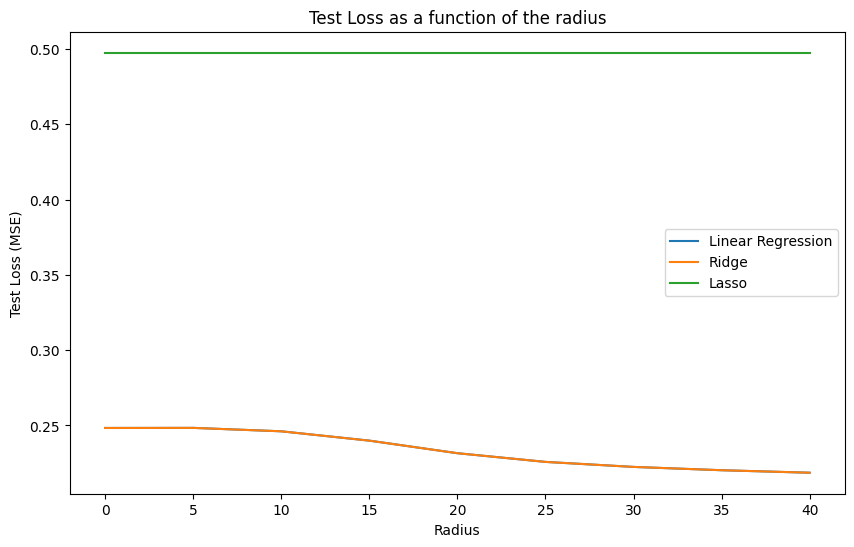

In [25]:
with open('xenium_competing_results_training.json', 'r') as f:
    training_mse = json.load(f)

with open('xenium_competing_results_testing.json', 'r') as f:
    testing_mse = json.load(f)

# Extracting radius values and MSEs for each model
model_names = ['Linear Regression', 'Ridge', 'Lasso']
radius_values = [str(x) for x in sorted([int(x) for x in testing_mse.keys()])]
mse_values = {model_name: {r: sum(testing_mse[r][response_gene][model_name] for response_gene in testing_mse[r]) / len(testing_mse[r]) for r in radius_values} for model_name in model_names}

# Adjusting mse_values to reflect the sorted radius values
adjusted_mse_values = {model_name: {r: mse_values[model_name][r] for r in radius_values} for model_name in model_names}

# Load Elastic Net results from the JSON file
with open('xenium_elasticnet_test.json', 'r') as f:
    elastic_net_mse = json.load(f)

# Add Elastic Net model to the adjusted_mse_values dictionary
adjusted_mse_values['Elastic Net'] = {r: sum(elastic_net_mse[r][response_gene] for response_gene in elastic_net_mse[r]) / len(elastic_net_mse[r]) for r in radius_values}

# Load LightGBM results from the JSON file
with open('xenium_lightgbm_test.json', 'r') as f:
    lightbm_mse = json.load(f)

# Add LightGBM model to the adjusted_mse_values dictionary
adjusted_mse_values['LightGBM'] = {r: sum(lightbm_mse[r][response_gene] for response_gene in lightbm_mse[r]) / len(lightbm_mse[r]) for r in radius_values}

# Plotting the test loss as a function of the radius
plt.figure(figsize=(10, 6))
for model_name in model_names:
    plt.plot([int(r) for r in radius_values], [adjusted_mse_values[model_name][r] for r in radius_values], label=model_name)
plt.xlabel('Radius')
plt.ylabel('Test Loss (MSE)')
plt.title('Test Loss as a function of the radius')
plt.legend()
plt.show()

In [26]:
import pandas as pd

# Create a pandas dataframe from the adjusted_mse_values dictionary
df = pd.DataFrame.from_dict(adjusted_mse_values, orient='index')

# Display the dataframe
df


,0,5,10,15,20,25,30,35,40
Linear Regression,0.248318,0.248380,0.246099,0.239903,0.231554,0.225786,0.222454,0.220256,0.218598
Ridge,0.248305,0.248362,0.246099,0.239903,0.231554,0.225786,0.222454,0.220256,0.218598
Lasso,0.497483,0.497483,0.497483,0.497483,0.497483,0.497483,0.497483,0.497483,0.497483
Elastic Net,0.263376,0.263352,0.262367,0.259043,0.254801,0.252091,0.250673,0.249903,0.249394
LightGBM,0.187722,0.187725,0.185653,0.181215,0.176458,0.173491,0.171736,0.170519,0.169617


In [39]:
# Add DeepST Results:

# Adding DeepST results to the dataframe as a new index
deepst_values = [0.17787978053092957, 0.17800715565681458, 0.17862552404403687, 0.17598138749599457, 0.1716541051864624, 0.1700151413679123, 0.1691126525402069]
# Since the last two values don't exist yet, we'll append them to the existing radius values
radius_values.extend(['30', '35', '40'])  # Assuming these are the missing radius values
# Creating a dictionary for DeepST model with the provided values
deepst_mse = {r: value for r, value in zip(radius_values, deepst_values)}
# Adding the DeepST model to the dataframe as a new index
df.loc['DeepST'] = deepst_mse

df


,0,5,10,15,20,25,30,35,40
Linear Regression,0.248318,0.248380,0.246099,0.239903,0.231554,0.225786,0.222454,0.220256,0.218598
Ridge,0.248305,0.248362,0.246099,0.239903,0.231554,0.225786,0.222454,0.220256,0.218598
Lasso,0.497483,0.497483,0.497483,0.497483,0.497483,0.497483,0.497483,0.497483,0.497483
Elastic Net,0.481109,0.481118,0.481811,0.482411,0.482557,0.482560,0.482565,0.482575,0.482584
LightGBM,0.187338,0.187196,0.185066,0.180638,0.175880,0.172854,0.171217,0.169883,0.169059
DeepST,0.177880,0.178007,0.178626,0.175981,0.171654,0.170015,0.169113,NaN,NaN


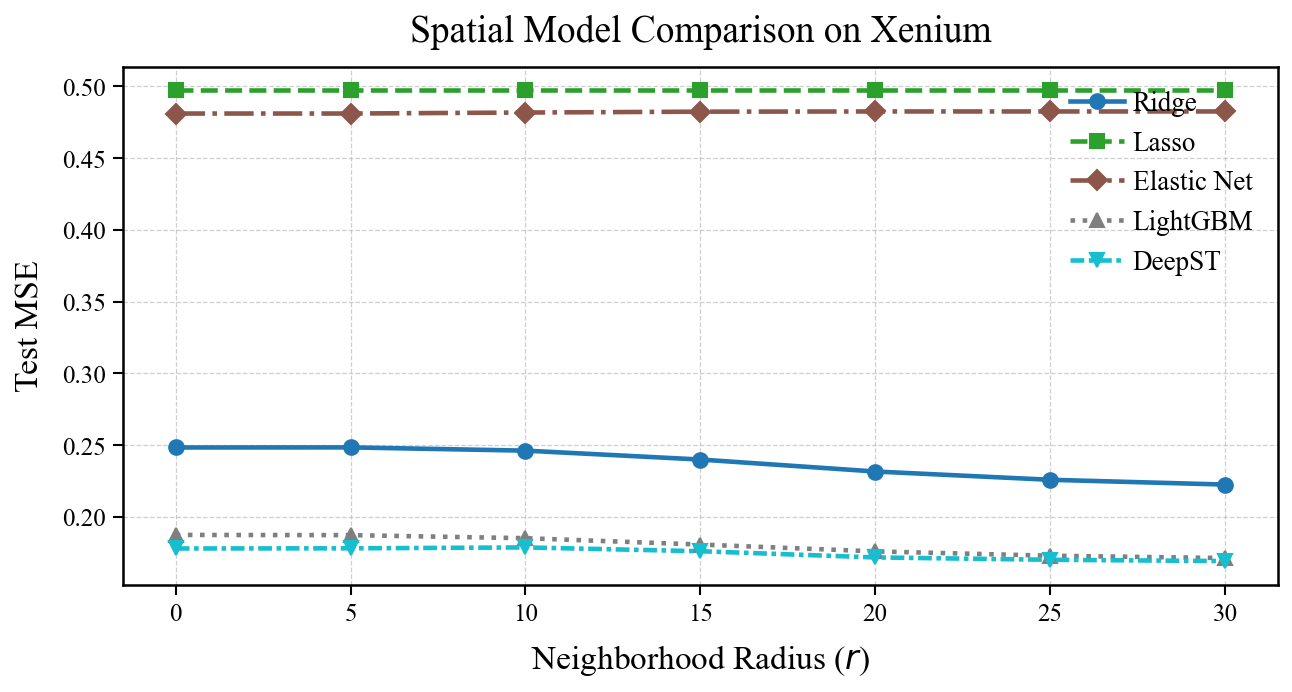

In [40]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Fonts and styles for ICML
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "font.size": 14,
    "legend.fontsize": 13,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.linewidth": 1.2,
    "legend.frameon": False,
    "figure.dpi": 150
})

# Markers, styles, colors (customized)
model_names = [m for m in df.index if m != 'Linear Regression']
markers = ['o', 's', 'D', '^', 'v', 'X', 'P', '*', 'h'][:len(model_names)]
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))][:len(model_names)]
colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

# Plot
fig, ax = plt.subplots(figsize=(9, 5))

for idx, model_name in enumerate(model_names):
    ax.plot(
        df.columns.astype(int)[:7],  # Only go from radius 0 to 30
        df.loc[model_name][:7],  # Only go from radius 0 to 30
        label=model_name,
        color=colors[idx],
        marker=markers[idx],
        linestyle=linestyles[idx],
        linewidth=2.2,
        markersize=7,
        markeredgewidth=1,
    )

# Axis + grid config
ax.set_xlabel(r'Neighborhood Radius ($r$)', labelpad=8)
ax.set_ylabel('Test MSE', labelpad=8)
ax.set_title('Spatial Model Comparison on Xenium', pad=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.6)

# Ticks + layout
ax.set_xticks(df.columns.astype(int)[:7])  # Only go from radius 0 to 30
ax.tick_params(axis='both', direction='out', length=5, width=1)

# Legend
ax.legend(loc='upper right', ncol=1, handletextpad=0.3, columnspacing=0.8)

# Tight layout + padding
fig.tight_layout(pad=1.5)

# Save or show
# fig.savefig("fig_xenium_comparison.pdf", bbox_inches='tight')
plt.show()


In [41]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
import warnings

warnings.filterwarnings('ignore')

# Define grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.005, 0.001],
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'min_data_in_leaf': [15, 20]
}

# Iterate over radius values
r_values = [30]
for r in tqdm(r_values, desc="Radius values"):
    nn = NearestNeighbors(radius=r)
    nn.fit(locations)
    indices = nn.radius_neighbors(locations, return_distance=False)

    neighbor_means = np.array([
        data[inds].mean(axis=0) if len(inds) > 0 else np.full(P, np.nan)
        for inds in indices
    ])

    if np.isnan(neighbor_means).any():
        raise ValueError("neighbor_means contains NaN values.")

    combined = np.hstack([data, neighbor_means])
    combined_df = pd.DataFrame(combined,
                                columns=list(xenium_df_inputs.columns) +
                                        [f"{col}_mean" for col in xenium_df_inputs.columns])

    for i, response_gene in enumerate(response_gene_names, start=1):
        print(f"\n🚀 Processing response gene {i}/{len(response_gene_names)}: {response_gene}")
        y = xenium_df_outputs[response_gene]
        X_train, X_test, y_train, y_test = train_test_split(
            combined_df, y, test_size=0.2, random_state=42
        )
        # Splitting the training data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        dtrain = lgb.Dataset(X_train, label=y_train)
        dvalid = lgb.Dataset(X_val, label=y_val)
        dtest = lgb.Dataset(X_test, label=y_test)

        best_score = float("inf")
        best_params = None
        best_model = None

        for param_combo in itertools.product(*param_grid.values()):
            params = dict(zip(param_grid.keys(), param_combo))
            full_params = {
                'objective': 'regression',
                'metric': 'mse',
                'verbosity': -1,
                'boosting_type': 'gbdt',
                **params
            }

            print(f"🔧 Trying: {full_params}")

            try:
                model = lgb.train(
                    params=full_params,
                    train_set=dtrain,
                    valid_sets=[dvalid],
                    callbacks=[lgb.early_stopping(stopping_rounds=30)],
                    num_boost_round=params['n_estimators'],
                )
                # Evaluating the model on the validation set
                val_preds = model.predict(X_val, num_iteration=model.best_iteration)
                mse = mean_squared_error(y_val, val_preds)

                if mse < best_score:
                    best_score = mse
                    best_params = full_params
                    best_model = model

            except Exception as e:
                print(f"⚠️ Failed: {params} — {e}")

        print(f"✅ Best params: {best_params}")
        print(f"✅ Validation MSE: {best_score:.4f}")
        # Evaluating the best model on the test set
        test_preds = best_model.predict(X_test, num_boost_round=best_model.best_iteration)
        test_mse = mean_squared_error(y_test, test_preds)
        print(f"✅ Test MSE: {test_mse:.4f}")
        break  # just first gene


Radius values:   0%|          | 0/1 [00:00<?, ?it/s]


🚀 Processing response gene 1/148: 2010300C02Rik
🔧 Trying: {'objective': 'regression', 'metric': 'mse', 'verbosity': -1, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'min_data_in_leaf': 15}
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.233906
🔧 Trying: {'objective': 'regression', 'metric': 'mse', 'verbosity': -1, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'min_data_in_leaf': 20}
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.233892
🔧 Trying: {'objective': 'regression', 'metric': 'mse', 'verbosity': -1, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'min_data_in_leaf': 15}
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.2101

Radius values:   0%|          | 0/1 [03:44<?, ?it/s]


KeyboardInterrupt: 

### Loading from jsons.